In [1]:
#import tensorflow
import numpy as np
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#from tensorflow import keras
#from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
#from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
#from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
#import tensorflow.keras.backend as K
#K.set_floatx('float16')
#K.set_epsilon(1e-4) 

In [2]:
import time

cc = 1.0
width = 900
height = 480
pp_cut = 210
DIM=(width, height)
K=np.array([[DIM[0]/2/cc, 0.0, DIM[0]/2], [0.0, DIM[1]/2/cc, (DIM[1])/2], [0.0, 0.0, 1.0]])
Dfish = np.array([[-0.09],[-0.13],[-0.0],[-0.0]])
D=np.array([-0.20, -0.03, 0.01, 0.0, -0.0])

h,w = DIM
fmap1, fmap2 = cv2.fisheye.initUndistortRectifyMap(K, Dfish, np.eye(3), K, DIM, cv2.CV_16SC2)
map1, map2 = cv2.initUndistortRectifyMap(K,D,None,K,DIM,5)

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 135, 450, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

def postprocess(img):
    return img[pp_cut:,:,:]

def read_img(fpath):
    mat = np.zeros((height, width, 3), dtype=np.uint8)
    img = cv2.imread(fpath)
    mat[:, int(width/2-640/2):int(width/2+640/2), :] = img
    return mat

def undistorted(img, fisheye=True):
    h,w = img.shape[:2]
    mmap1, mmap2 = map1, map2
    if fisheye:
        mmap1, mmap2 = fmap1, fmap2
    return cv2.remap(img, mmap1, mmap2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

def transform(img, undistort=False):
    t0 = time.time()
    img = cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), -1)
    if undistort:
        img = postprocess(undistorted(img))
    print("Transform is: {}".format(time.time()-t0))
    return img

def resize(image):
    t0 = time.time()
    res = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    print("Resize is: {}".format(time.time()-t0))
    return res

def rgb2yuv(image):
    t0 = time.time()
    im = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    print("YUV is: {}".format(time.time()-t0))
    return im

def normalize(x):
    return x/127.5-1.0

def disp(img):
    plt.figure()
    plt.imshow(img)

In [3]:
%matplotlib inline
fpath = '/Users/oskarimantere/git/PyImageStream/set4/img_150.jpg'
fpath2 = '/Users/oskarimantere/testimg.jpg'
#fpath2 = '/home/omantere/selfdrive/PyImageStream/calibration_img_74.jpg'
img = read_img(fpath)
img2 = cv2.imread(fpath2)
#img2 = read_img(fpath2)
disp(preprocess_input(img))
disp(img2)
#disp(resize(transform(imgg, undistort=True)))
#disp(resize(transform(imgg)))

NameError: name 'preprocess_input' is not defined

In [14]:
n_samples

5755

Old angle: 0.5
Transform is: 0.002593994140625
Resize is: 0.00037932395935058594
YUV is: 0.0006542205810546875
New angle: 0.5093384658483955

Old angle: -0.3087921738624573
Transform is: 0.0011949539184570312
Resize is: 0.0003330707550048828
YUV is: 0.0003299713134765625
New angle: 0.31452869209305967

Old angle: 0.31285154819488525
Transform is: 0.0015597343444824219
Resize is: 0.0003781318664550781
YUV is: 0.0002980232238769531
New angle: -0.22557444770817597

Old angle: -0.18866008520126343
Transform is: 0.002086162567138672
Resize is: 0.00035881996154785156
YUV is: 0.0005040168762207031
New angle: 0.18866008520126343

Old angle: 0.5
Transform is: 0.0013759136199951172
Resize is: 0.0003387928009033203
YUV is: 0.0002980232238769531
New angle: 0.5224510332914994

Old angle: -0.2833471894264221
Transform is: 0.002454996109008789
Resize is: 0.00035500526428222656
YUV is: 0.0004341602325439453
New angle: 0.28021985805680627

Old angle: 0.4507288336753845
Transform is: 0.00140166282653808

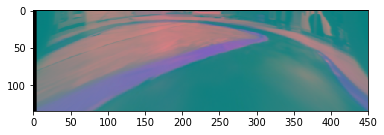

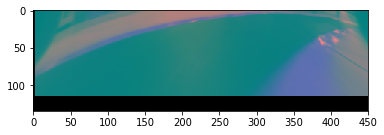

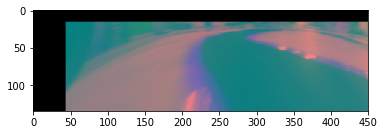

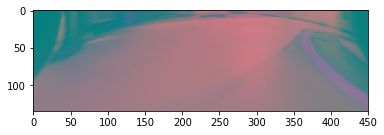

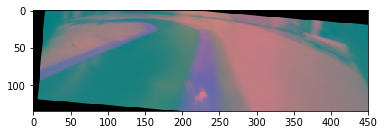

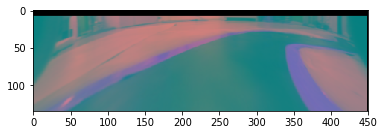

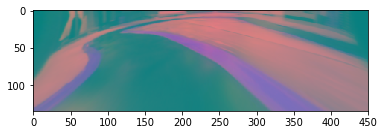

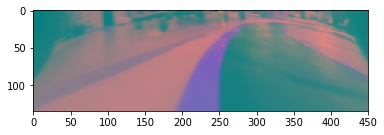

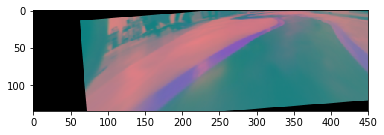

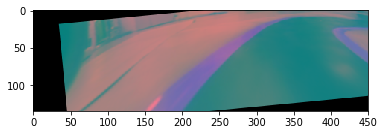

In [11]:
for k in np.random.randint(100,500,10):
    steering_angle = get_output(k)
    print("Old angle: {}".format(steering_angle))
    img, angle = augment(preprocess_input(get_input(k)), steering_angle)
    print("New angle: {}".format(angle))
    print()
    disp(img)

In [12]:
import os
from collections import defaultdict
import time
image_paths_set = defaultdict(dict)
action_paths_set = defaultdict(dict)
images = np
actions = []
total_sets = 5
sets = range(1,total_sets+1)
sets = [11, 21, 31, 41, 61, 51]
for tr_set in sets:
    for root, dirs, files in os.walk("./git/PyImageStream/set{}".format(tr_set)):
        for filename in files:
            if "img_" in filename:
                image_paths_set[tr_set][int(filename.split('img_')[1].split('.jpg')[0])] = os.path.join(root, filename)
            if "actions_" in filename:
                action_paths_set[tr_set][int(filename.split('actions_')[1])] = os.path.join(root, filename)

valid_split = 0.15
image_paths = {}
action_paths = {}
image_paths_valid = {}
action_paths_valid = {}
n_samples = 0
n_valid_samples = 0
for tr_set in sets:
    for ind in image_paths_set[tr_set]:
        if np.random.uniform(0, 1) < valid_split:
            image_paths_valid[n_valid_samples] = image_paths_set[tr_set][ind]
            action_paths_valid[n_valid_samples] = action_paths_set[tr_set][ind]
            n_valid_samples += 1
        else:
            image_paths[n_samples] = image_paths_set[tr_set][ind]
            action_paths[n_samples] = action_paths_set[tr_set][ind]
            n_samples += 1

            
def get_input(i):
    return read_img(image_paths[i])

def preprocess_input(img):
    return rgb2yuv(resize(transform(img, undistort=True)))

def read_action(fpath):
    return np.float32([float(x) for x in open(fpath, 'r').read().strip().split()])

def get_output(i):
    return read_action(action_paths[i])[1] - 0.5

def augment(img, steering_angle, prob=0.5):
    if np.random.uniform(0, 1) > 0.5: # Horizontal flip
        img = cv2.flip(img, 1)
        steering_angle = -steering_angle
    M = np.float32([[1,0,0],[0,1,0]])
    if np.random.uniform(0, 1) > prob: # Rotation
        rot = np.random.normal(0, 4)
        if rot > 8:
            rot = 8
        if rot < -8:
            rot = -8
        M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2),rot,1)
    if np.random.uniform(0, 1) > 0.5:  # Translation
        xx = np.random.normal(0, 50)
        yy = np.random.normal(0, 10)
        if xx > 100:
            xx = 100
        if xx < -100:
            xx = -100
        if yy < -20:
            yy = -20
        if yy > 20:
            yy = 20
        M[0,2] += xx
        M[1,2] += yy
        steering_angle += xx * 0.002
        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    return img, steering_angle

def image_generator(image_paths, action_paths, batch_size = 32, train = True):  
    while True:
        # Select files (paths/indices) for the batch
        batch_indices = np.random.randint(0, len(image_paths), batch_size)
        batch_input = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for i in batch_indices:
            input = get_input(i)
            output = get_output(i)
            if train:
                input, new_steering_angle = augment(input, output)
                output = new_steering_angle
            input = preprocess_input(input)
            batch_input += [ input ]
            batch_output += [ output ]
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )

        yield( batch_x, batch_y )


In [13]:
def nvidia(dropout=0.2):
    model = Sequential()
    model.add(Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2), input_shape=INPUT_SHAPE))
    model.add(Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2)))
    model.add(Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2)))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', strides=(2, 2)))
    model.add(Conv2D(80, kernel_size=(3, 5), activation='relu'))
    model.add(Conv2D(80, kernel_size=(3, 5), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.summary()

    return model

In [6]:
from adabound import AdaBound
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

optm = AdaBound(lr=1e-03,
                final_lr=0.1,
                gamma=1e-03,
                weight_decay=0.,
                amsbound=False)
optm = Adam(lr=1e-04)

n = 100
epochs = 1000
batch_size = 32
steps_per_epoch = 100
model = nvidia()

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

model.compile(optm, loss='mean_squared_error')
H = model.fit_generator(
    image_generator(image_paths, action_paths, batch_size=batch_size), 
    validation_data=image_generator(image_paths_valid, action_paths_valid, batch_size=batch_size, train=False),
    epochs=epochs, 
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch * valid_split,
    callbacks=[checkpoint],
    workers=4,
)

ModuleNotFoundError: No module named 'adabound'